<a href="https://colab.research.google.com/github/Sumisumisumith/StridedTransformer/blob/main/StridedTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#ファイルにstrided transformerをクローン

%cd /content/drive/MyDrive/MyColab
!git clone https://github.com/Vegetebird/StridedTransformer-Pose3D.git

/content/drive/MyDrive/MyColab
Cloning into 'StridedTransformer-Pose3D'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 226 (delta 36), reused 47 (delta 24), pack-reused 165
Receiving objects: 100% (226/226), 28.37 MiB | 7.54 MiB/s, done.
Resolving deltas: 100% (94/94), done.


In [1]:
#StridedTransformer-Pose3Dに必要なライブラリをインストール

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!pip install --upgrade gdown
!pip install yacs
!pip install filterpy
!pip install einops
!pip install yt-dlp moviepy
!pip install matplotlib==3.7.1

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=b98e669bd499a9aed575f41f2a45b32419f103d6ee29097f3817783ba7c83752
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 948.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 k

In [2]:
#インストールした各ライブラリをインポート

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

import os
from yt_dlp import YoutubeDL

from moviepy.video.fx.resize import resize
from moviepy.editor import VideoFileClip, AudioFileClip, ImageSequenceClip, CompositeAudioClip
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D


In [3]:
#学習済みモデルダウンロード

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
!mkdir -p ./checkpoint/pretrained

if not os.path.exists('checkpoint/pretrained/refine_4365.pth'):
  !gdown https://drive.google.com/uc?id=1aDLu0SB9JnPYZOOzQsJMV9zEIHg2Uro7 -O checkpoint/pretrained/refine_4365.pth
if not os.path.exists('checkpoint/pretrained/no_refine_4365.pth'):
  !gdown https://drive.google.com/uc?id=1l63AI9BsNovpfTAbfAkySo9X2MOWgYZH -O checkpoint/pretrained/no_refine_4365.pth

if not os.path.exists('demo/lib/checkpoint/yolov3.weights'):
  !gdown https://drive.google.com/uc?id=1gWZl1VrlLZKBf0Pfkj4hKiFxe8sHP-1C -O demo/lib/checkpoint/yolov3.weights
if not os.path.exists('demo/lib/checkpoint/pose_hrnet_w48_384x288.pth'):
  !gdown https://drive.google.com/uc?id=1CpyZiUIUlEjiql4rILwdBT4666S72Oq4 -O demo/lib/checkpoint/pose_hrnet_w48_384x288.pth

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D


In [4]:
#StridedTransformer/demo/videoに、youtubeから切り取った入力動画を配置

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

video_url = 'https://youtu.be/0wVKezD0Czw' #@param {type:"string"}

#@markdown 動画の切り抜き範囲(秒)を指定してください。\
#@markdown 30秒以上の場合OOM発生の可能性が高いため注意
start_sec =  0#@param {type:"integer"}
end_sec =  8#@param {type:"integer"}

(start_pt, end_pt) = (start_sec, end_sec)

download_resolution = 360
full_video_path = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/full_video.mp4'
file_name = 'input_clip.mp4'
input_clip_path = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/' + file_name

# 動画ダウンロード
ydl_opts = {'format': f'best[height<={download_resolution}]', 'overwrites': True, 'outtmpl': full_video_path}
with YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])

# 指定区間切り抜き
with VideoFileClip(full_video_path) as video:
    subclip = video.subclip(start_pt, end_pt)
    subclip.write_videofile(input_clip_path)

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
[youtube] Extracting URL: https://youtu.be/0wVKezD0Czw
[youtube] 0wVKezD0Czw: Downloading webpage
[youtube] 0wVKezD0Czw: Downloading ios player API JSON
[youtube] 0wVKezD0Czw: Downloading android player API JSON
[youtube] 0wVKezD0Czw: Downloading m3u8 information
[info] 0wVKezD0Czw: Downloading 1 format(s): 18
Deleting existing file /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/full_video.mp4
[download] Destination: /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/full_video.mp4
[download] 100% of    2.76MiB in 00:00:00 at 3.65MiB/s   
Moviepy - Building video /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/input_clip.mp4.
MoviePy - Writing audio in input_clipTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/input_clip.mp4



Moviepy - Done !
Moviepy - video ready /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/video/input_clip.mp4


In [5]:
#入力ファイルを指定してvis.pyを実行する(実行結果はStridedTransformer/demo/output/input_clip/input_clip.mp4)

%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!python demo/vis.py --video {file_name}

output = VideoFileClip('/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/output/input_clip/input_clip.mp4')
output = resize(output, height=420)
output.ipython_display()

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

Generating 2D pose...
100% 240/240 [00:34<00:00,  6.99it/s]
Generating 2D pose successful!

Generating 3D pose...
  8% 20/240 [00:19<03:17,  1.11it/s]/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/vis.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure( figsize=(9.6, 5.4))
100% 240/240 [03:50<00:00,  1.04it/s]
/content/output.csv にデータが書き込まれました。
Generating 3D pose successful!

Generating demo...
100% 300/300 [04:17<00:00,  1.16it/s]
Generating demo successful!
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


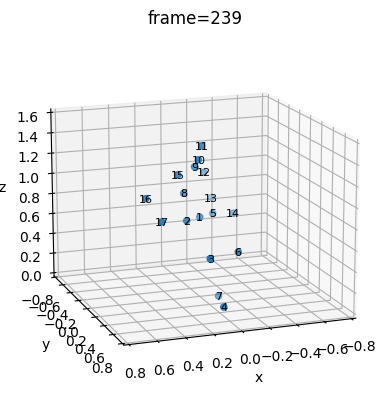

In [30]:
#vis.pyのpost_outから得た関節情報から3Dグラフを作成
import csv
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML

# CSVファイル名
csv_filename = '/content/output.csv'

# 17行3列のデータを読み取る関数
def read_3d_data(file, batch_size=17):
    data = []
    with open(file, mode='r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        batch = []
        for row in reader:
            batch.append([float(val) for val in row])
            if len(batch) == batch_size:
                data.append(batch)
                batch = []
    return data

# 三次元座標データの読み込み
data = read_3d_data(csv_filename)
data = np.array(data) #tuple型から変換

# プロットの準備
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=15., azim=70)

# タイトルを設定
frame_number = 0  # 初期フレーム数
title = ax.set_title("frame")

ax.set_xlim([-0.8, 0.8])  # x軸の範囲を設定
ax.set_ylim([-0.8, 0.8])  # y軸の範囲を設定
ax.set_zlim([0, 1.6])  # z軸の範囲を設定

# X、Y、Z軸にラベルを設定
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

sc = ax.scatter([], [], [], marker='o')

# フレーム更新用の関数
def update(frame):

    sc._offsets3d = (data[frame][:, 0], data[frame][:, 1], data[frame][:, 2])

    # タイトルを更新
    title.set_text('frame={}'.format(frame))

    # 凡例を追加
    for text in ax.texts: #前フレームの凡例を削除
        text.set_visible(False)

    for i, (x, y, z) in enumerate(zip(data[frame][:, 0], data[frame][:, 1], data[frame][:, 2]), start=1): #現フレームの凡例作成
        ax.text(x, y, z, str(i), fontsize=8, ha='center', va='center')

    return sc, title

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=len(data), blit=False)

# 動画ファイルの保存
Writer = animation.writers['ffmpeg']
writer = Writer(fps=30, metadata=dict(artist='Me'), bitrate=1800)
ani.save('/content/output.mp4', writer=writer)

# プロットの表示（任意）
plt.show()

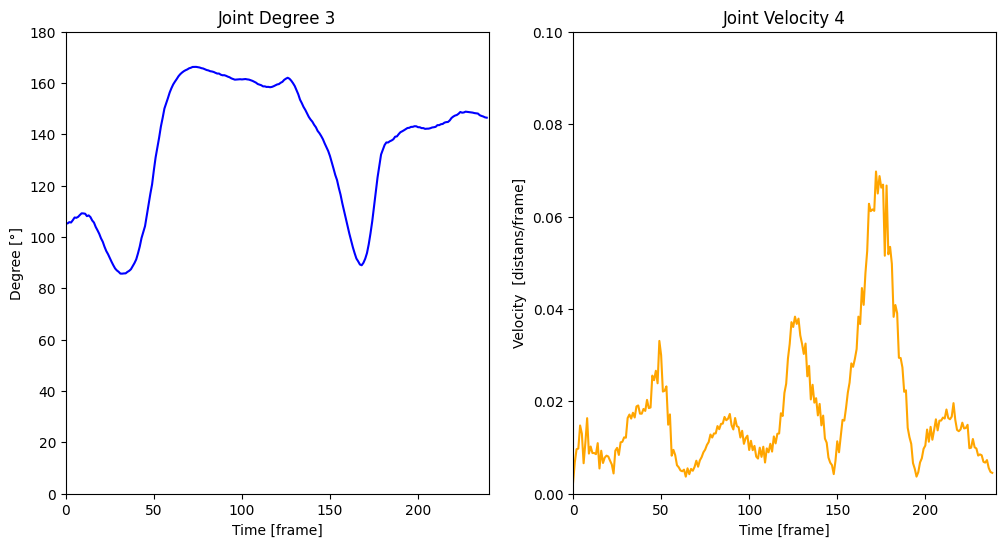

In [48]:
#関節角度＆速度の計算
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# 17行3列ずつデータを読み取る関数
def read_3d_data(file, batch_size=17):
    data = []
    with open(file, mode='r', newline='') as csvfile:
        reader = csv.reader(csvfile)
        batch = []
        for row in reader:
            batch.append([float(val) for val in row])
            if len(batch) == batch_size:
                data.append(batch)
                batch = []
    return data

# 関節角度を計算する関数
def joint_deg(data, joint_num):
    deg = []
    joint_num = joint_num - 1
    for frame in range(len(data)):
        a = data[frame][joint_num - 1] - data[frame][joint_num]
        b = data[frame][joint_num + 1] - data[frame][joint_num]
        x = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        rad = math.acos(x)
        deg.append(math.degrees(rad))
    return deg

# 関節速度を計算する関数
def joint_v(data,joint_num):
    v = []
    joint_num = joint_num - 1
    for frame in range(len(data)-1):
        d = data[frame+1][joint_num] - data[frame][joint_num]
        v.append(np.linalg.norm(d))
    return v

# CSVファイル名
csv_filename = '/content/output.csv'

# 三次元関節座標データの読み込み
data = read_3d_data(csv_filename)
data = np.array(data) #tuple型から変換

fig = plt.figure(figsize=(12,6)) #グラフ用意

# 関節角度グラフ表示
deg_3 = joint_deg(data, 3)
t = np.arange(len(data))

ax_deg_3 = fig.add_subplot(1, 2, 1)
ax_deg_3.set_title("Joint Degree 3")
ax_deg_3.set_xlabel("Time [frame]")
ax_deg_3.set_ylabel("Degree [°]")
ax_deg_3.set_xlim([0, 240])
ax_deg_3.set_ylim([0, 180])
ax_deg_3.plot(t, deg_3, color="blue")

# 関節速度グラフ表示
v_4 = joint_v(data, 4)
t = np.arange(len(data)-1)

ax_v_3 = fig.add_subplot(1, 2, 2)
ax_v_3.set_title("Joint Velocity 4")
ax_v_3.set_xlabel("Time [frame]")
ax_v_3.set_ylabel("Velocity  [distans/frame]")
ax_v_3.set_xlim([0, 240])
ax_v_3.set_ylim([0, 0.1])
ax_v_3.plot(t, v_4, color="orange")

plt.show()

In [ ]:
#フォルダの削除
import shutil

directory = '/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/StridedTransformer'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

#同名のフォルダを作成する
#os.mkdir(directory)

In [ ]:
#pythonのバージョン確認

!python --version

Python 3.10.12


In [ ]:
#sample videoでの実行
%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

#videoフォルダに任意のビデオを配置
!python demo/vis.py --video sample_video.mp4


Generating 2D pose...
100% 255/255 [00:40<00:00,  6.32it/s]
Generating 2D pose successful!

Generating 3D pose...
  8% 20/255 [00:12<02:14,  1.74it/s]/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/demo/vis.py:224: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure( figsize=(9.6, 5.4))
100% 255/255 [02:40<00:00,  1.59it/s]
/content/output.csv にデータが書き込まれました。
Generating 3D pose successful!

Generating demo...
100% 255/255 [03:38<00:00,  1.17it/s]
Generating demo successful!


In [ ]:
%cd /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D

!git remote remove origin
!git init
!git remote add origin https://github.com/Sumisumisumith/StridedTransformer
!git add .
!git commit -m "Initial commit"
!git push -u origin main

/content/drive/MyDrive/MyColab/StridedTransformer-Pose3D
Reinitialized existing Git repository in /content/drive/MyDrive/MyColab/StridedTransformer-Pose3D/.git/
On branch main
nothing to commit, working tree clean
fatal: could not read Username for 'https://github.com': No such device or address
